In [ ]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import matplotlib.pyplot as plt
import glob

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
model = SentenceTransformer('clip-ViT-B-32')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Here we use the Unsplash Dataset Lite, which contains about 25k images.

In [19]:
#!wget https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/unsplash-25k-photos.zip

In [20]:
#!unzip 'unsplash-25k-photos.zip' -d 'photos'

In [ ]:
# here we only use the first 3000 photos to make computation fast
img_names = list(glob.glob('photos/*.jpg'))[:3000]
print(len(img_names))

3000


In [ ]:
# show image
#a = Image.open(img_names[0])
#a

In [ ]:
# embedding images
img_embed = model.encode([Image.open(img) for img in img_names], batch_size=32, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
threshold = 0.8 # threshold of cosine similarity
min_community_size=5 # min size of cluster
init_max_size=1000

In [ ]:
# calculate cosine similaity matrix
cos_scores = util.cos_sim(img_embed, img_embed)
cos_scores.shape

torch.Size([3000, 3000])

In [ ]:
top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)
top_k_values.shape

torch.Size([3000, 5])

In [ ]:
extracted_communities = []

for i in range(len(top_k_values)):
  if top_k_values[i][-1] >= threshold:
    new_cluster = []

    top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
    top_idx_large = top_idx_large.tolist()
    top_val_large = top_val_large.tolist()

    if top_val_large[-1] < threshold:
      for idx, val in zip(top_idx_large,top_val_large):
        if val<threshold:
          break

        new_cluster.append(idx)

    else:
      for idx,val in enumerate(cos_scores[i].tolist()):
        if val>=threshold:
          new_cluster.append(idx)


    extracted_communities.append(new_cluster)


extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

In [ ]:
unique_communities = []
extracted_ids = set()

for community in extracted_communities:
  add_cluster = True
  for idx in community:
    if idx in extracted_ids:
      add_cluster = False
      break

  if add_cluster:
    unique_communities.append(community)
    for idx in community:
      extracted_ids.add(idx)

In [ ]:
# number of clusters
len(unique_communities)

42



Cluster Size:  839


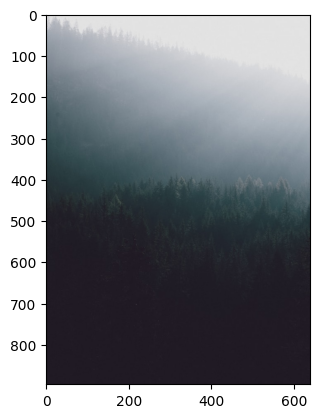

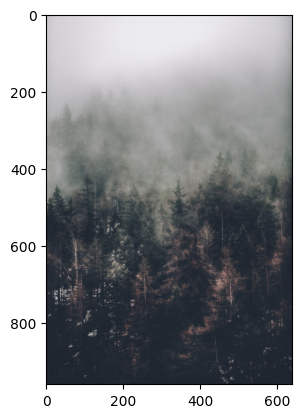

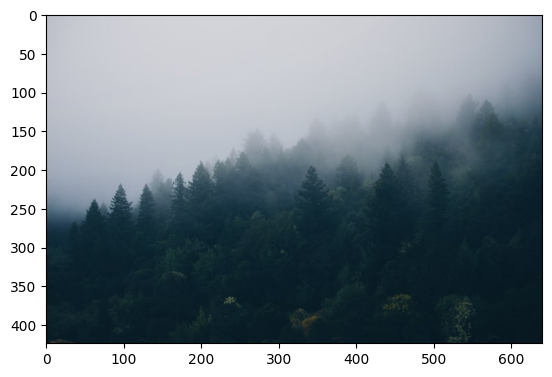



Cluster Size:  101


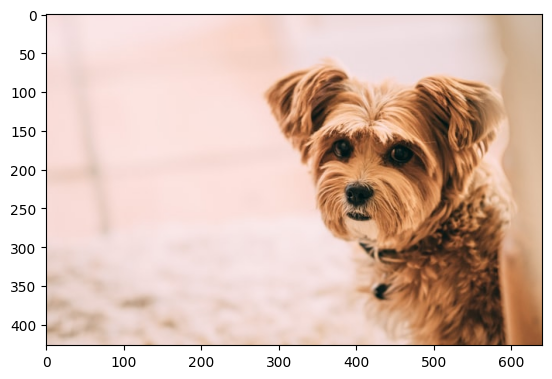

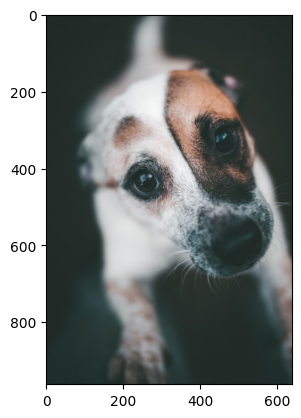

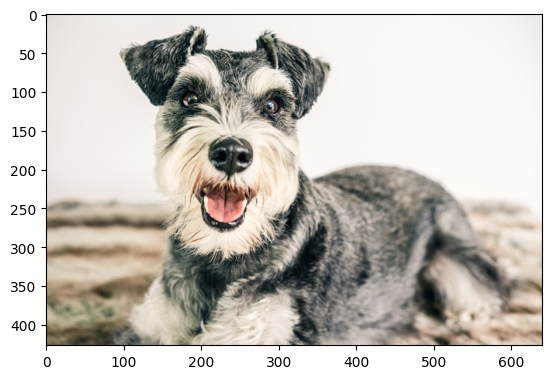



Cluster Size:  41


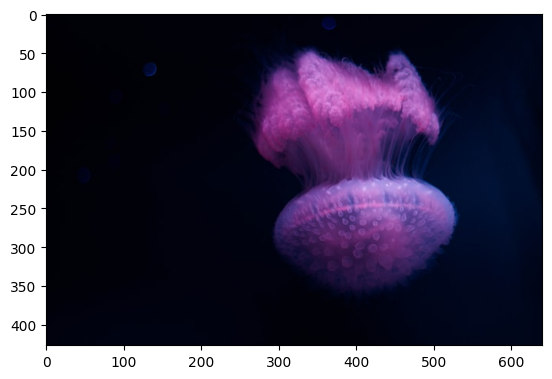

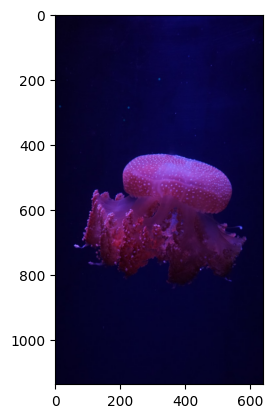

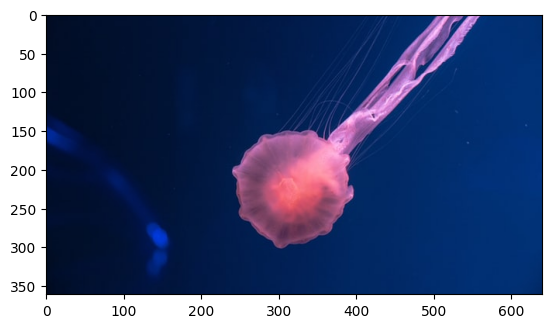



Cluster Size:  29


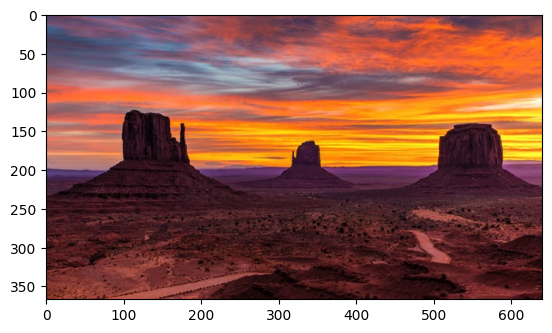

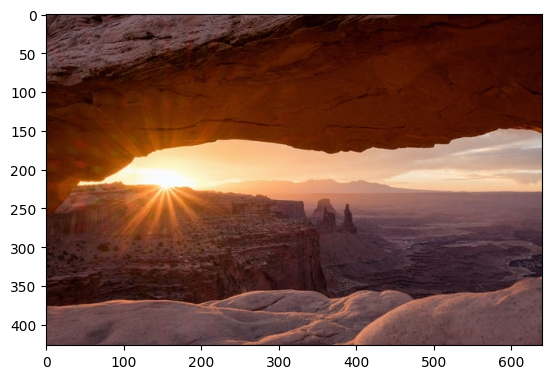

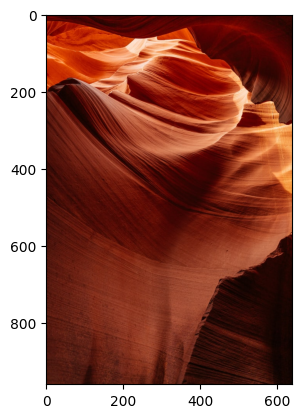



Cluster Size:  27


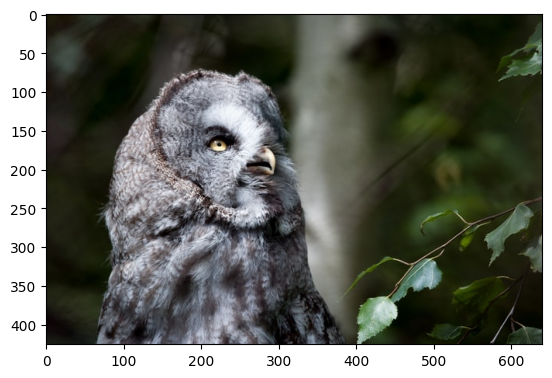

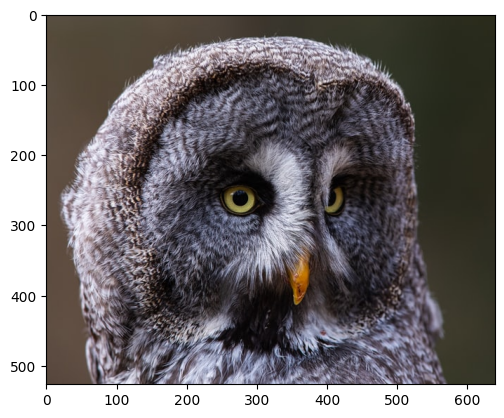

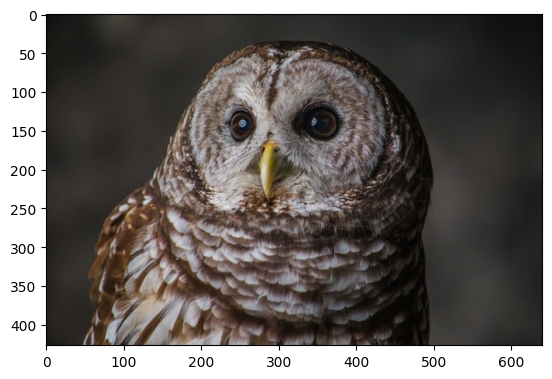



Cluster Size:  27


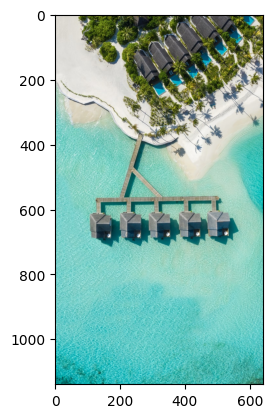

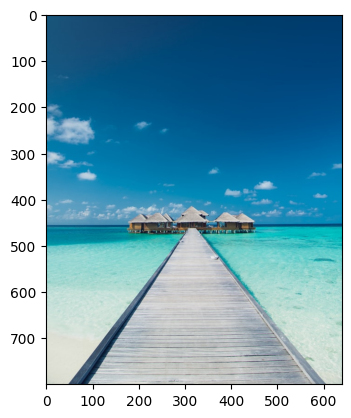

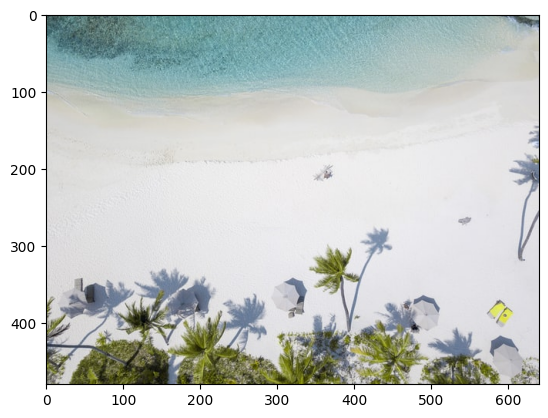



Cluster Size:  24


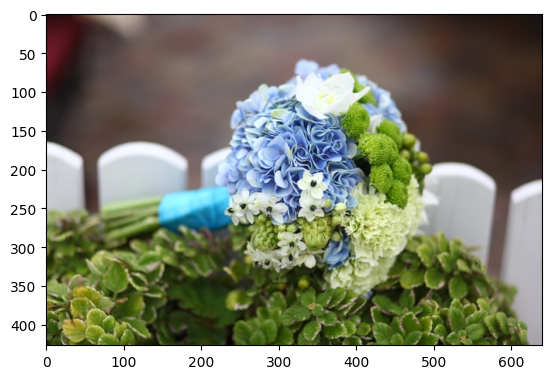

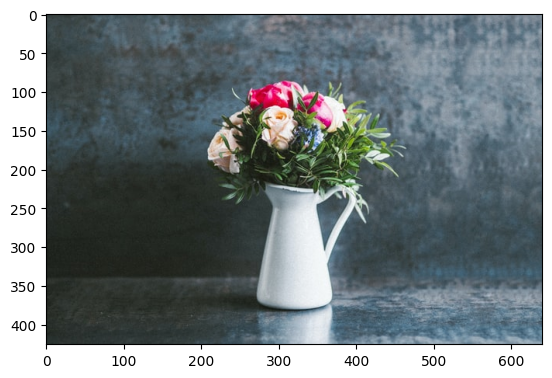

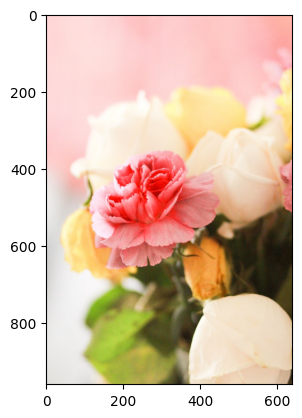



Cluster Size:  22


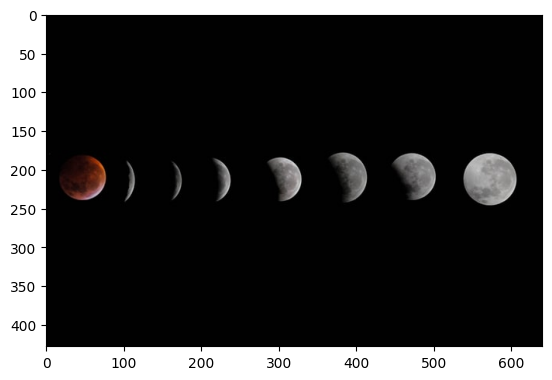

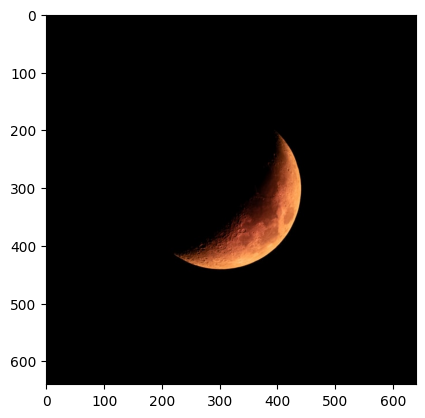

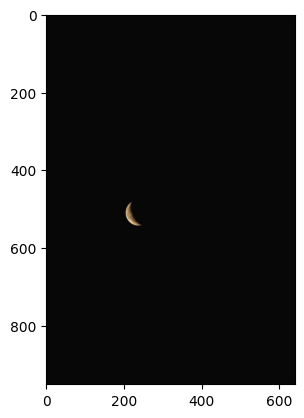



Cluster Size:  17


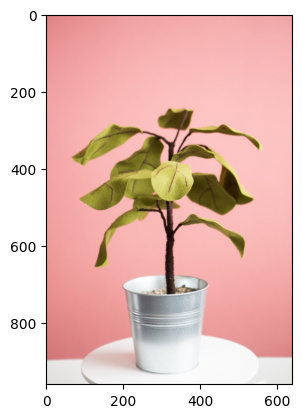

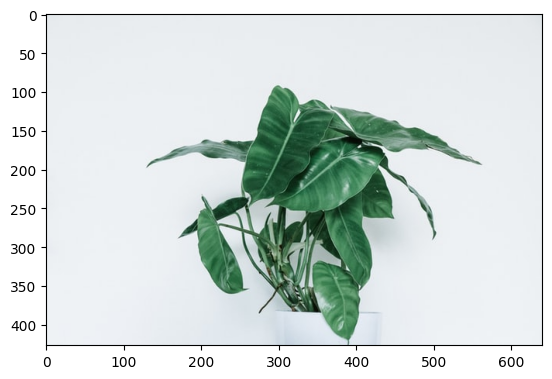

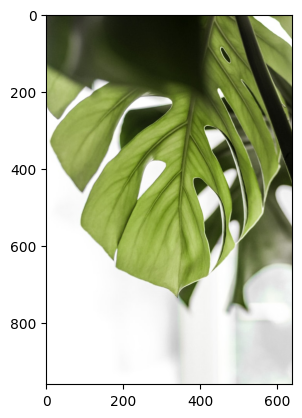



Cluster Size:  16


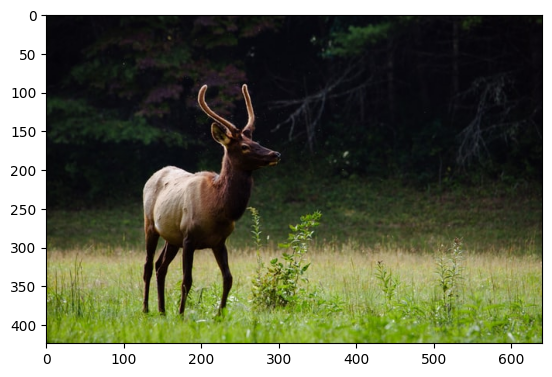

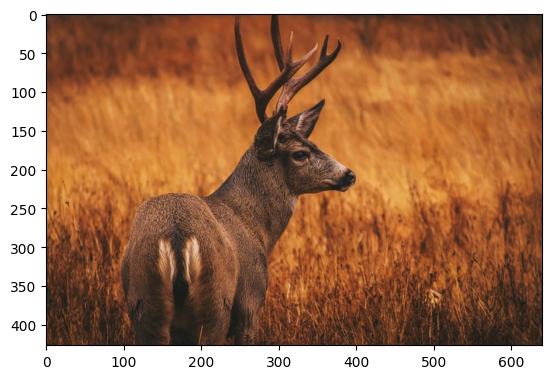

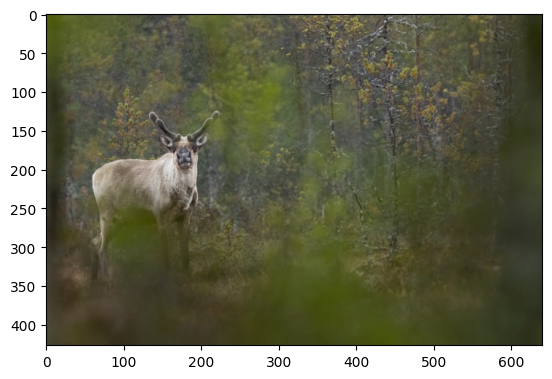

In [ ]:
# show 3 images in the top 10 clusters
for cluster in unique_communities[0:10]:
  print("\n\nCluster Size: ", len(cluster))

  for idx in cluster[0:3]:
    img_path = img_names[idx]
    im = Image.open(img_path)
    plt.figure()
    plt.imshow(im)
    plt.show()